In [31]:
import re
import nltk
import string
import unicodedata
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
from nltk.corpus import stopwords
from keras.models import Sequential
from nltk import wordpunct_tokenize
from keras.models import load_model
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

nltk.download('punkt')
nltk.download('omw')
nltk.download('wordnet')
nltk.download('stopwords')

review_col = "review_description"
rating_col = "rating"


df = pd.read_excel('train_subset.xlsx')

print(df.head(10))

stopwords_list_arabic = stopwords.words('arabic')
# stopwords_list_english = stopwords.words('english')
print(stopwords_list_arabic,'\n')


Num GPUs Available:  1


[nltk_data] Downloading package punkt to /home/hazem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw to /home/hazem/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hazem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hazem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                  review_description  rating
0  شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...      -1
1  خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...       1
2  تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...      -1
3  فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...       1
4  سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...      -1
5  قعد عشرين سنة يدور على سائق بس اما عن توصيل ال...       0
6                                         احلئ تطبيق       1
7                                      رائع واو مدهش       1
8  مکو بس البحرین وعمان وغیرهه بس العراق مکو یعنی...      -1
9                    تطبيق جميل يستاهل الخمس نجوم👍👍👍       1
['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آ

In [32]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)


def remove_emojis(text):
  return ''.join(c for c in text if not unicodedata.combining(c))

def is_english_word(word) :
    alpha = "abcdefghijklmnopqrstuvwxyz"
    for i in word:
        if i in alpha :
            return True
    return False


def remove_punctuations(word):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
    translator = str.maketrans('', '', punctuations_list)
    return word.translate(translator)



def preprocess_review(sentence):
    sentence = str(sentence)
    words = wordpunct_tokenize(sentence)
    non_english_words = [word for word in words if not is_english_word(word)]
    cleaned_sentence = ' '.join(non_english_words)
    
    cleaned_sentence = remove_emojis(cleaned_sentence)
    cleaned_sentence = normalize_arabic(cleaned_sentence)
    cleaned_sentence = remove_repeating_char(cleaned_sentence)
    cleaned_sentence = remove_punctuations(cleaned_sentence)
    
    return cleaned_sentence

def preprocess_dataframe(df, review_col=review_col):
    tokenizer = RegexpTokenizer(r'\w+')
    df[review_col] = df[review_col].apply(preprocess_review)

    df[review_col] = df[review_col].apply(tokenizer.tokenize)

    df[review_col] = df[review_col].apply(lambda x: [item for item in x if item not in stopwords_list_arabic])

    arabic_stemmer = ISRIStemmer()
    df[review_col] = df[review_col].apply(lambda x: [arabic_stemmer.stem(word) for word in x])

In [33]:
# print(df.head(30))
preprocess_dataframe(df)
print(df.head(30))


                                   review_description  rating
0   [شرك, زبل, سوق, رشم, فيش, حتي, رقم, شكو, سوق, ...      -1
1   [خدم, دفع, طرق, الك, نت, وقف, عند, اصبح, فقط, ...       1
2   [طبق, غبي, جري, حذف, عمل, كود, خصم, خدم, كتر, ...      -1
3   [فعل, طبق, تاز, مكن, يتح, خدم, طبق, ان, تطع, ت...       1
4            [سيء, جدا, سعر, رسم, وصل, تمت, لقع, صله]      -1
5   [قعد, سنه, يدر, علي, سئق, اما, وصل, شيء, جيد, ...       0
6                                          [حلئ, طبق]       1
7                                          [رئع, دهش]       1
8   [مکو, حری, وعم, غیر, عرق, مکو, یعنی, نجم, وحد,...      -1
9                           [طبق, جمل, تهل, خمس, نجم]       1
10                                              [طلب]       1
11                               [سمر, عمر, ريق, مصر]       1
12  [تاز, صدق, ودق, سرع, وصل, رجء, وضع, تقم, علي, ...       1
13                                   [هالبرنامج, نقذ]       1
14                     [مره, سرع, جني, طلب, نصح, صرح]       1
15      

Length of 'positive' column Before: 1172
Length of 'negative' column Before: 725
Length of 'neutral' column Before: 102
5970 total words in positive, with a vocabulary size of 1531


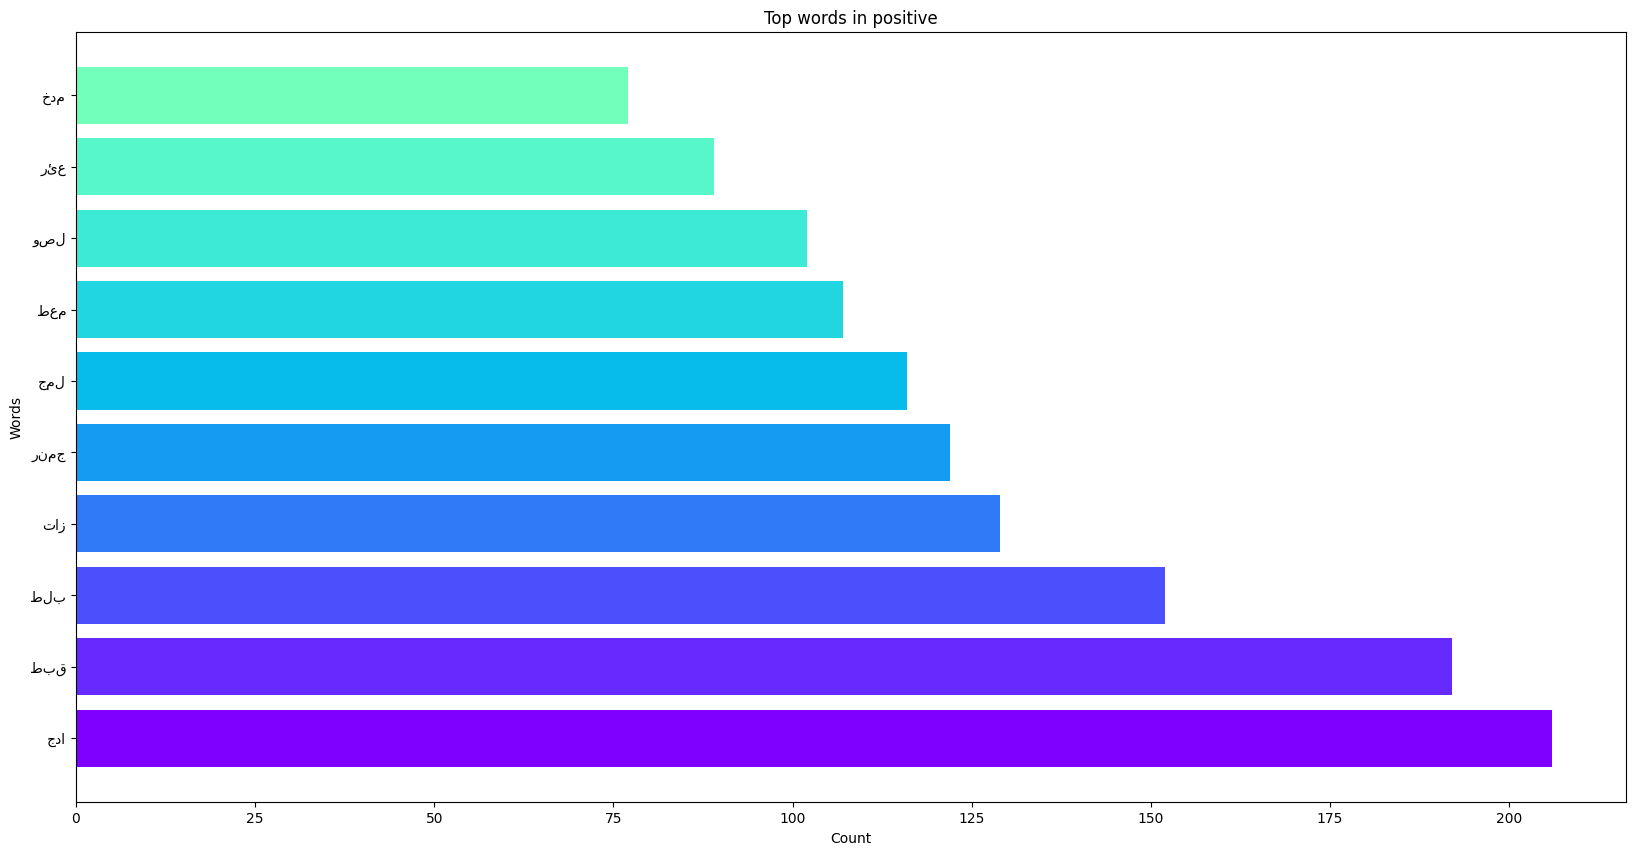

951 total words in neutral, with a vocabulary size of 514


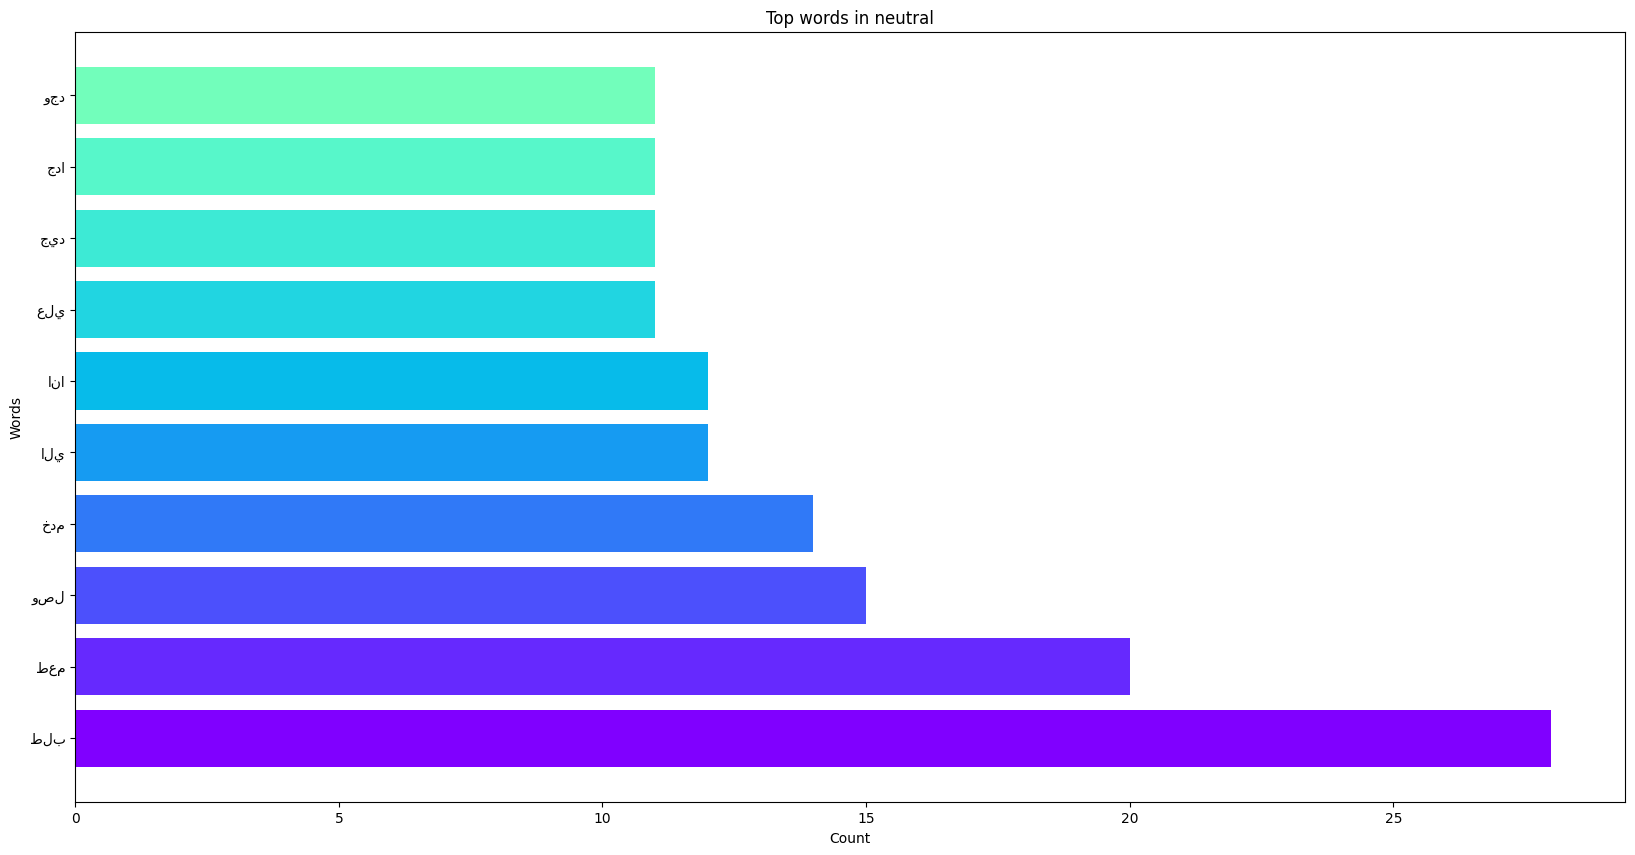

8719 total words in negative, with a vocabulary size of 1952


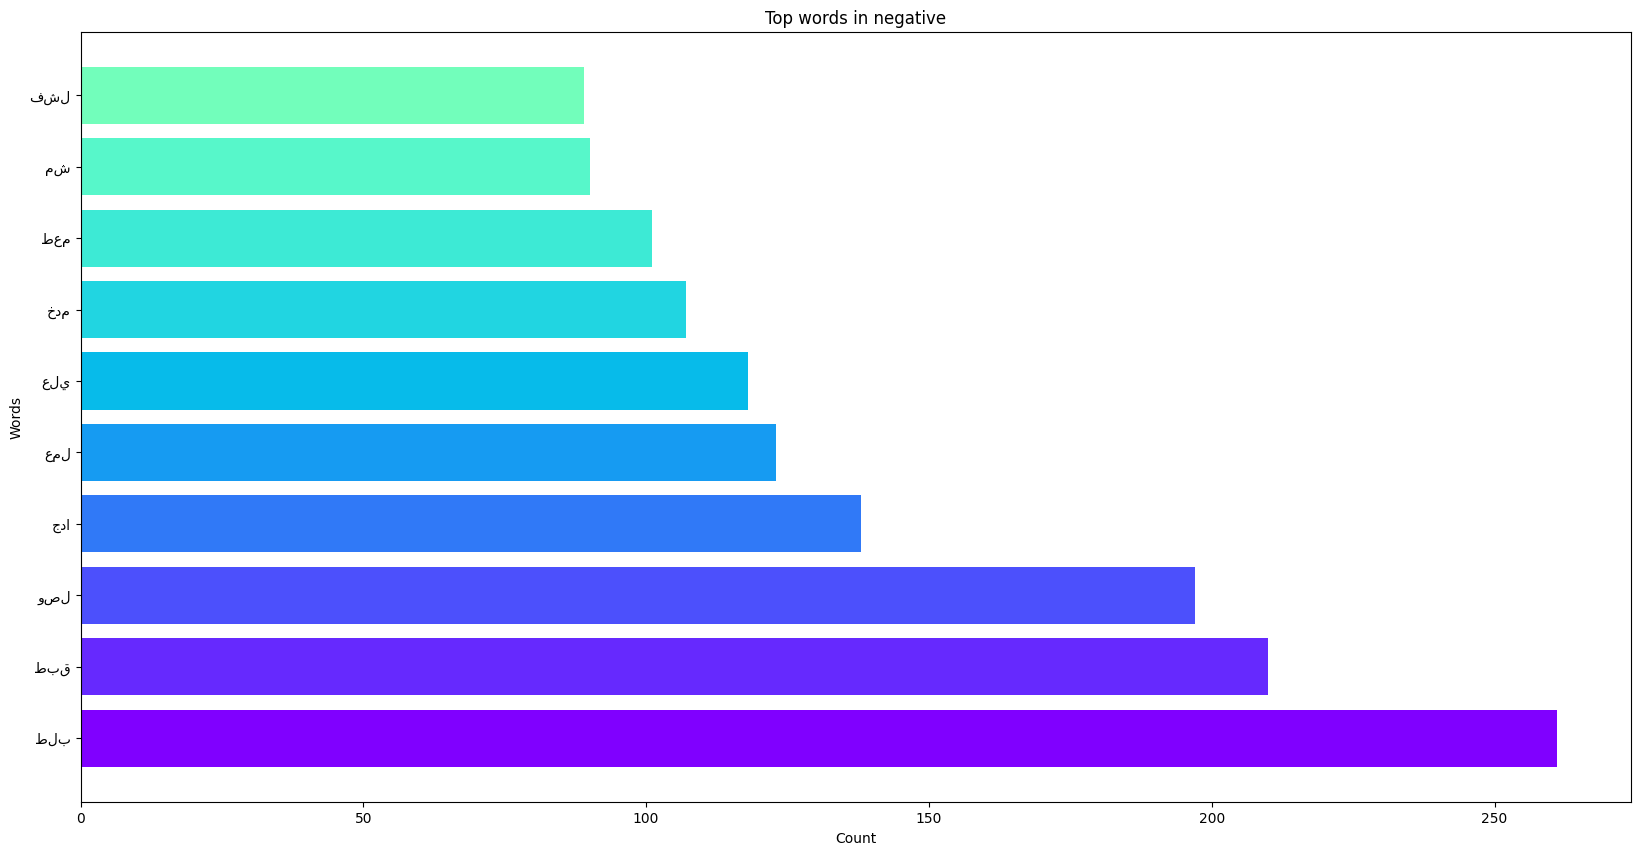

Total Words in TOTal 3997


In [34]:
pos = []
neg = []
neu = []

df[rating_col] = df[rating_col].replace({-1: 0, 0: 1, 1: 2})

for i in range(len(df[rating_col])) : 
    if df[rating_col][i] == 1:
        neu.append(df[review_col][i])

    if df[rating_col][i] == 2:
        pos.append(df[review_col][i])

    if df[rating_col][i] == 0:
        neg.append(df[review_col][i])



# Display the updated DataFrame Before
print(f"Length of 'positive' column Before: {len(pos)}")
print(f"Length of 'negative' column Before: {len(neg)}")
print(f"Length of 'neutral' column Before: {len(neu)}")


def display_stats(col,col_name):
    all_words = []

    for sentence in col :
        for word in sentence :
            all_words.append(word)

    VOCAB = sorted(list(set(all_words)))

    print(f"%s total words in {col_name}, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

    counter = Counter(all_words)
    counter.most_common(35)


    counted_words = Counter(all_words)

    words = []
    counts = []
    for letter, count in counted_words.most_common(10):
        words.append(letter)
        counts.append(count)

    colors = cm.rainbow(np.linspace(0, 1, 20))
    rcParams['figure.figsize'] = 20, 10

    plt.title('Top words in ' + col_name)
    plt.xlabel('Count')
    plt.ylabel('Words')
    plt.barh(words, counts, color=colors)
    plt.show()

    return len(VOCAB)



tot_words = 0
for col in [(pos,"positive"), (neu,"neutral"), (neg,"negative")]:
    tot_words += display_stats(col[0] ,col[1] )

print("Total Words in TOTal " + str(tot_words))

In [36]:
# Create new columns 'positive', 'negative', and 'neutral' based on the 'rating' column
# Identify the two minimum lengths

mxLen = max(len(pos), len(neg), len(neu))

X = df.drop('rating', axis=1)
y = df['rating']
oversampler = RandomOverSampler(sampling_strategy={0: mxLen, 1: mxLen, 2: mxLen})

X_resampled, y_resampled = oversampler.fit_resample(X, y)


df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='rating')], axis=1)

print(df.head(20))

                                   review_description  rating
0   [شرك, زبل, سوق, رشم, فيش, حتي, رقم, شكو, سوق, ...       0
1   [خدم, دفع, طرق, الك, نت, وقف, عند, اصبح, فقط, ...       2
2   [طبق, غبي, جري, حذف, عمل, كود, خصم, خدم, كتر, ...       0
3   [فعل, طبق, تاز, مكن, يتح, خدم, طبق, ان, تطع, ت...       2
4            [سيء, جدا, سعر, رسم, وصل, تمت, لقع, صله]       0
5   [قعد, سنه, يدر, علي, سئق, اما, وصل, شيء, جيد, ...       1
6                                          [حلئ, طبق]       2
7                                          [رئع, دهش]       2
8   [مکو, حری, وعم, غیر, عرق, مکو, یعنی, نجم, وحد,...       0
9                           [طبق, جمل, تهل, خمس, نجم]       2
10                                              [طلب]       2
11                               [سمر, عمر, ريق, مصر]       2
12  [تاز, صدق, ودق, سرع, وصل, رجء, وضع, تقم, علي, ...       2
13                                   [هالبرنامج, نقذ]       2
14                     [مره, سرع, جني, طلب, نصح, صرح]       2
15      

In [41]:
for i in range(len(df[review_col])) :
    df[review_col][i] = ' '.join(df[review_col][i])
    


max_words = 5000 # top x most frequent words
max_len = 200 # max sentece len, it will truncate

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df[review_col])
sequences = tokenizer.texts_to_sequences(df[review_col])
X = pad_sequences(sequences, maxlen=max_len)

y = np.array(df[rating_col])

/tmp/ipykernel_19884/731623725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[review_col][i] = ' '.join(df[review_col][i])


In [43]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))
model1.summary()


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)
y_train_one_hot = to_categorical(y_train, num_classes=3)

checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)

history = model1.fit(X_train, y_train_one_hot, epochs=70, validation_data=(X_val, y_val_one_hot), callbacks=[checkpoint1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 20)          100000    
                                                                 
 lstm_6 (LSTM)               (None, 15)                2160      
                                                                 
 dense_6 (Dense)             (None, 3)                 48        
                                                                 
Total params: 102208 (399.25 KB)
Trainable params: 102208 (399.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/70
76/77 [============================>.] - ETA: 0s - loss: 1.0713 - accuracy: 0.4239
Epoch 1: val_accuracy improved from -inf to 0.44972, saving model to best_model1.hdf5
77/77 [==============================] - 6s 41ms/step - loss: 1.0704 - accuracy: 0.4238 - val_loss

/home/hazem/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/77 [===========================>..] - ETA: 0s - loss: 1.0264 - accuracy: 0.4840
Epoch 2: val_accuracy improved from 0.44972 to 0.50474, saving model to best_model1.hdf5
77/77 [==============================] - 1s 19ms/step - loss: 1.0252 - accuracy: 0.4852 - val_loss: 1.0312 - val_accuracy: 0.5047
Epoch 3/70
77/77 [==============================] - ETA: 0s - loss: 1.0093 - accuracy: 0.5047
Epoch 3: val_accuracy improved from 0.50474 to 0.52941, saving model to best_model1.hdf5
77/77 [==============================] - 2s 23ms/step - loss: 1.0093 - accuracy: 0.5047 - val_loss: 1.0136 - val_accuracy: 0.5294
Epoch 4/70
77/77 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.5169
Epoch 4: val_accuracy improved from 0.52941 to 0.54459, saving model to best_model1.hdf5
77/77 [==============================] - 1s 17ms/step - loss: 0.9891 - accuracy: 0.5169 - val_loss: 0.9949 - val_accuracy: 0.5446
Epoch 5/70
75/77 [============================>.] - ETA: 0s - loss: 0.97

17/17 [==============================] - 0s 7ms/step - loss: 0.7666 - accuracy: 0.6856
[0.7666430473327637, 0.685606062412262]
